# Analysis of Money Supply in the Eurozone
Money supply in the Eurozone is not much different from that in the US and is made up of the following money aggregates:

Type of money | MB | M1 | M2 | M3
--- | --- | --- | --- | ---
Currency in circulation | ✓ | ✓ | ✓ | ✓
Reserve balances | ✓ |  |   |  
Overnight deposits (aka Demand deposits) |  | ✓ | ✓ | ✓ 
Deposits with an agreed maturity of up to 2 years or redeemable at notice of up to 3 months |  |  | ✓ | ✓
Repurchase agreements, Money market funds, Debt securities with maturity of up to 2 years |  |  |  | ✓

As you can see from the above table, `MB` currency in circulation < `M1` < `M2` < `M3` as each of the larger money supply aggregates includes the preceeding one. I use both nominal and real measures by deflating nominal measures with Eurozone's Harmonized Index of Consumer Prices (HICP).

I make use of the datasets provided by the ECB to carry out this analysis. In contrast to the Fed, which stopped publishing data on M3 in 2006, the ECB still does it.

Analogously with [the Money supply analysis for the US](./Money_Supply.ipynb) I use not seasonally adjusted datasets. Likewise, I derived real money supply in parts of this notebook by using consumer price index as the deflator.

Towards the end of this notebook I take a look at the evolution of reserve balances at the ECB, even though these balances are not part of money supply available to private individuals and companies, it neveretheless plays an indirect role in money supply.

In [1]:
# Uncomment if running in Google Colaboratory

# Install the latest version of pandaSDMX
# !pip install sdmx1 -U
# !pip install eurostat -U

In [2]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from pandas.tseries.offsets import BDay

import eurostat
import sdmx

from datetime import date

from dateutil.relativedelta import relativedelta

In [3]:
report_start = date.fromisoformat('2008-10-01')
report_end = date.today()

### Preparing factors for conversion from nominal to real amounts by adjusing for monthly Harmonized Index of Consumer Prices (HICP &mdash; Eurozone's CPI)

In [4]:
# Using Eurozone price index 2015=100, and All-items HICP: CP00 
eu_hicp = eurostat.get_data_df('prc_hicp_midx',
               filter_pars={'startPeriod': report_start, 'unit': 'I15', 'coicop': 'CP00', 'geo': 'EA'}).iloc[:, 3:]
eu_hicp = eu_hicp.set_index(eu_hicp.columns[0]).T
eu_hicp = eu_hicp.set_axis(pd.DatetimeIndex(eu_hicp.index, 'MS'))

## Analysis of annual changes in the main components of M3

In [5]:
# M.U2.N.V.L10.X.1.U2.2300.Z01.E <-- Currency in circulation
# M.U2.N.V.M10.X.1.U2.2300.Z01.E <-- M1
# M.U2.N.V.M20.X.1.U2.2300.Z01.E <-- M2
# M.U2.N.V.M30.X.1.U2.2300.Z01.E <-- M3
# Retrieving them all in one go                               
ecb = sdmx.Client('ECB')  
data_msg = ecb.data('BSI', key='M.U2.N.V..X.1.U2.2300.Z01.E', params={'startPeriod': report_start, 
                                                                      'endPeriod': report_end})

In [6]:
df = sdmx.to_pandas(data_msg.data[0]).loc['M', 'U2', 'N', 'V', :, 'X', '1', 'U2', '2300', 'Z01', 'E'].unstack(-2)
df.columns.names = [None]

In [7]:
m1_addons = (df.loc[:, 'M10'] - df.loc[:, 'L10']).rename('M1 Add-ons')
m2_addons = (df.loc[:, 'M20'] - df.loc[:, 'M10']).rename('M2 Add-ons')
m3_addons = (df.loc[:, 'M30'] - df.loc[:, 'M20']).rename('M3 Add-ons')

In [8]:
m3_df = pd.concat([df.loc[:, ['M30', 'L10']], m1_addons, m2_addons, m3_addons], axis=1)
m3_df = m3_df.set_axis(pd.DatetimeIndex(m3_df.index, 'MS'))
m3_df.rename(columns={'L10': 'MB Currency in circulation', 'M30': 'M3 Total'}, inplace=True)

# Converting into billions of Euros
m3_df /= 1000.

In [9]:
m3_df

,M3 Total,MB Currency in circulation,M1 Add-ons,M2 Add-ons,M3 Add-ons
TIME_PERIOD,,,,,
2008-10-01,9326.351030,698.783573,3245.683158,4027.655269,1354.229030
2008-11-01,9367.448353,703.623942,3266.057343,4049.303799,1348.463269
2008-12-01,9423.780086,722.746037,3312.996312,4067.314628,1320.723109
2009-01-01,9400.007135,712.198952,3383.950818,4005.742439,1298.114926
2009-02-01,9414.394921,715.828862,3386.039071,3991.931310,1320.595678
...,...,...,...,...,...
2025-05-01,16931.964591,1564.132663,9242.050395,4938.150627,1187.630906
2025-06-01,16924.541322,1570.098979,9282.846704,4896.844507,1174.751132
2025-07-01,16950.149175,1575.610237,9263.305499,4918.626491,1192.606947


In [10]:
last_idx = min(eu_hicp.index[-1], m3_df.index[-1])
eu_hicp = eu_hicp.loc[:last_idx]
# Convert into pandas.Series
nom_2_real_conv_factors = (eu_hicp.iloc[-1] / eu_hicp).iloc[:,0].rename('Conversion factor')

# Convert from nominal into real money supply
m3real_df = m3_df.multiply(nom_2_real_conv_factors, axis=0).dropna()

m3real_df.rename(
    columns={m3_df.columns[0]: 'Real ' + m3_df.columns[0], m3_df.columns[1]: 'Real ' + m3_df.columns[1],
             m3_df.columns[2]: 'Real ' + m3_df.columns[2], m3_df.columns[3]: 'Real ' + m3_df.columns[3]},
    inplace=True)

In [11]:
m3real_df

,Real M3 Total,Real MB Currency in circulation,Real M1 Add-ons,Real M2 Add-ons,M3 Add-ons
TIME_PERIOD,,,,,
2008-10-01,13115.054474,982.654909,4564.197861,5663.835522,1904.366182
2008-11-01,13237.567860,994.323035,4615.414367,5722.255603,1905.574854
2008-12-01,13334.643670,1022.685247,4687.887971,5755.247975,1868.822477
2009-01-01,13412.445414,1016.204502,4828.406508,5715.612875,1852.221529
2009-02-01,13378.405079,1017.234625,4811.759299,5672.767561,1876.643595
...,...,...,...,...,...
2025-05-01,17028.004484,1573.004589,9294.472282,4966.160339,1194.367274
2025-06-01,16967.803124,1574.112400,9306.575127,4909.361615,1177.753982
2025-07-01,16990.844235,1579.393068,9285.545467,4930.435462,1195.470238


## Visualization of Eurozone's Nominal M3 Money Supply

In [12]:
M3_COMPOSITION_TITLE = 'Composition of Eurozone M3 Money Supply'
REALM3_COMPOSITION_TITLE = 'Composition of Eurozone Real M3 Money Supply'
IN_EURO_FORMATER = ' in {:%Y-%m} Euros'
LEFT_Y_AXIS_LABEL = 'Billions of Euros'

### Stacked Visualization Amounting to Total Eurozone M3 Money Supply

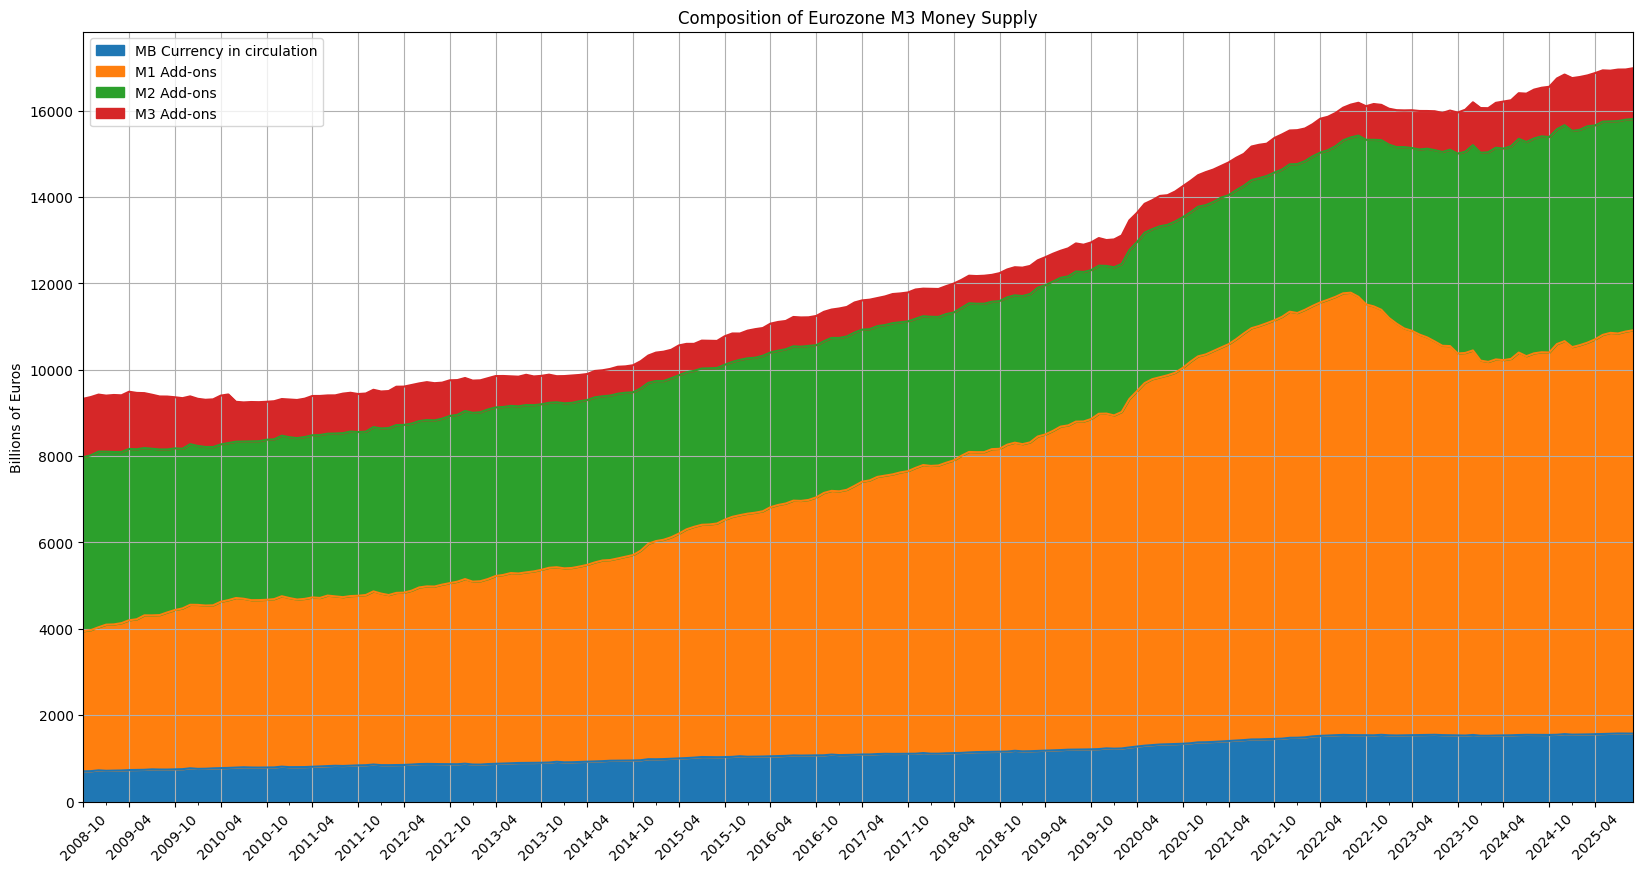

In [13]:
ax = m3_df.iloc[:,1:].plot.area(figsize=(20,10), grid=True, title=M3_COMPOSITION_TITLE,
                     xticks=m3_df.index[::6], xlabel='', rot=45,
                     ylabel=LEFT_Y_AXIS_LABEL)#, yticks=np.arange(0, 25e3, 2.5e3))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m3_df.index[::6])))

In [14]:
idxmax = m3_df.iloc[:,0].idxmax()
print('Nominal M3 money supply maximum of \u20ac{:>8.2f}bn reached in month {:%Y-%m}'
      .format(m3_df.loc[idxmax, m3_df.columns[0]], idxmax))
print('Nominal M3 money supply changed by  \u20ac{:>8.2f}bn since (as of month {:%Y-%m})'
      .format(m3_df.iloc[-1,0]-m3_df.loc[idxmax, m3_df.columns[0]], m3_df.index[-1]))
print('Nominal M3 money supply changed by  \u20ac{:>8.2f}bn since {:%Y-%m} to \u20ac{:.2f}bn'
      .format(m3_df.iloc[-1,0]-m3_df.iloc[-2,0], m3_df.index[-2], m3_df.iloc[-1,0]))

Nominal M3 money supply maximum of €16981.61bn reached in month 2025-09
Nominal M3 money supply changed by  €    0.00bn since (as of month 2025-09)
Nominal M3 money supply changed by  €   29.85bn since 2025-08 to €16981.61bn


In [15]:
m3_df.iloc[-1,:] - m3_df.iloc[-2,:]

M3 Total                      29.851402
MB Currency in circulation    -0.893317
M1 Add-ons                    30.279057
M2 Add-ons                   -14.287350
M3 Add-ons                    14.753013
dtype: float64

### Visualization as Percent of Total Eurozone M3 Money Supply

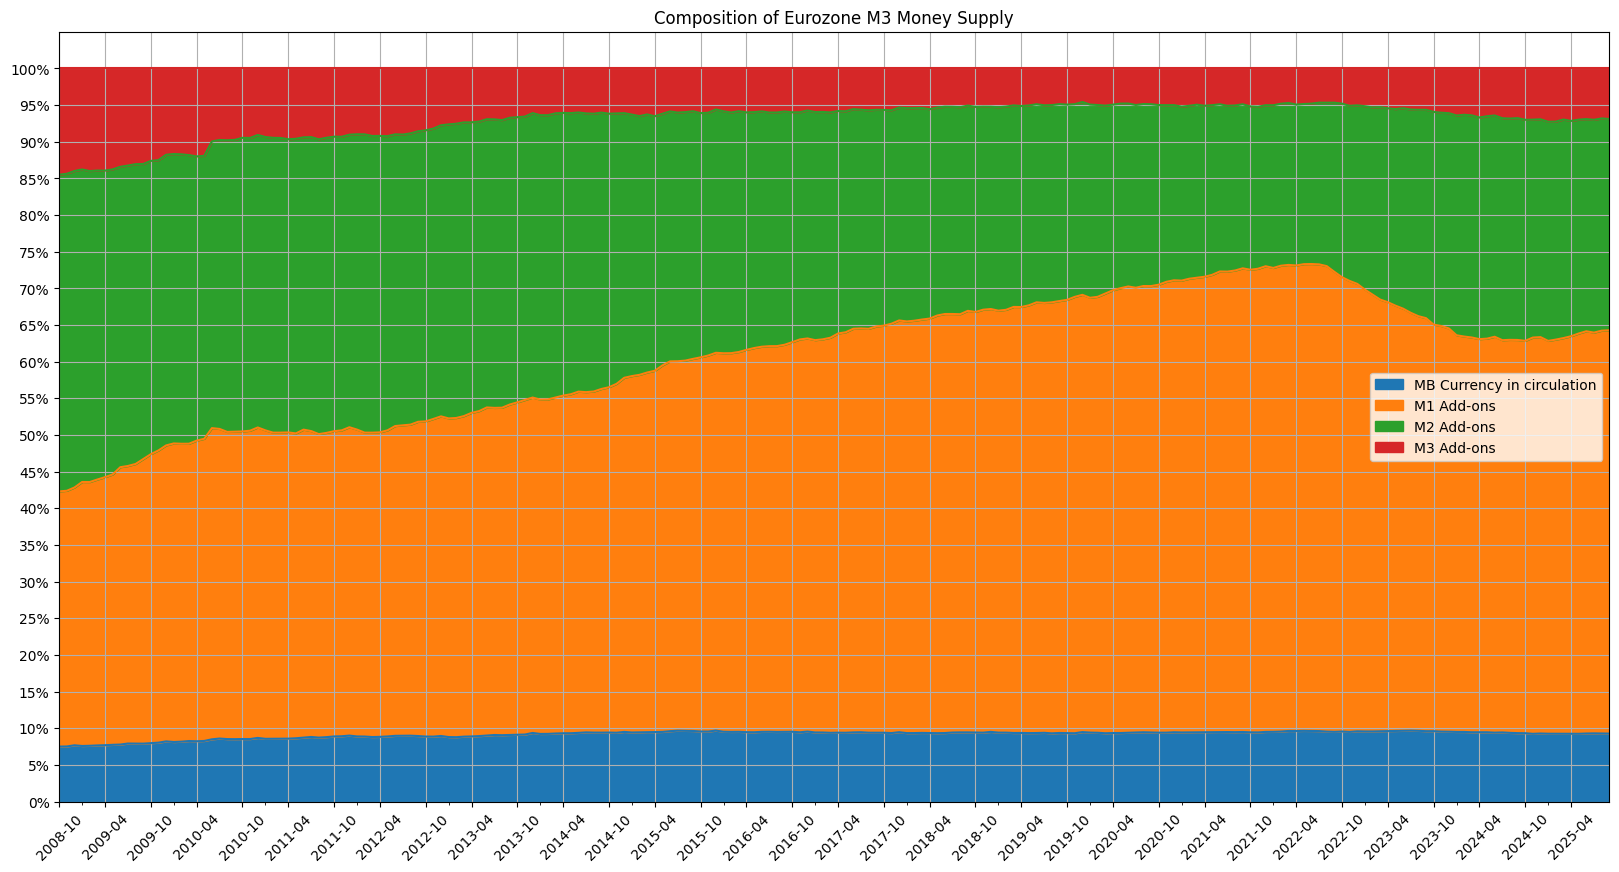

In [16]:
# Converting to percentages by dividing by total M3 Money Supply.
# Dividing by the total M3 Money Supply
m3_df_pct = m3_df.iloc[:,1:].divide(m3_df.iloc[:,0], axis=0)
m3_df_pct *= 100

ax = m3_df_pct.plot.area(figsize=(20,10), grid=True, title=M3_COMPOSITION_TITLE,
                         xticks=m3_df_pct.index[::6], xlabel='', rot=45,
                         yticks=np.arange(0, 101, 5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m3_df_pct.index[::6])))

In [17]:
m3_df_pct.iloc[-1,:] - m3_df_pct.iloc[-2,:]

MB Currency in circulation   -0.021588
M1 Add-ons                    0.081771
M2 Add-ons                   -0.135017
M3 Add-ons                    0.074834
dtype: float64

## Visualization of Eurozone's Real M3 Money Supply

### Stacked Visualization Amounting to Total Eurozone Real M3 Money Supply

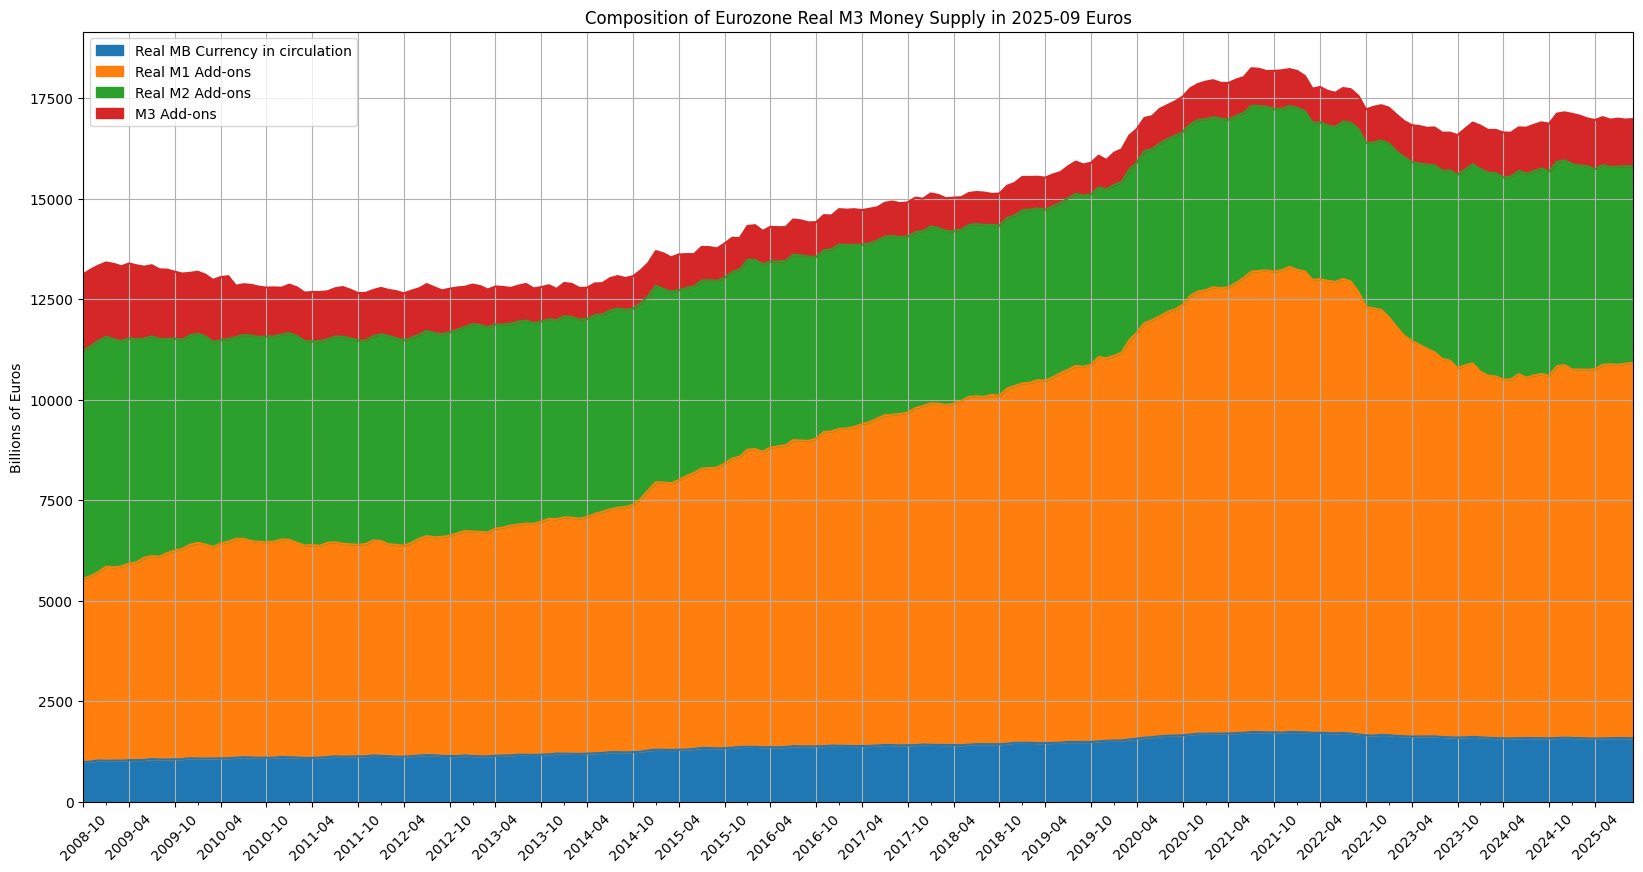

In [18]:
ax = m3real_df.iloc[:,1:].plot.area(
                figsize=(20,10), grid=True,
                title=REALM3_COMPOSITION_TITLE + IN_EURO_FORMATER.format(m3real_df.index[-1].date()),
                xticks=m3real_df.index[::6], xlabel='', rot=45,
                ylabel=LEFT_Y_AXIS_LABEL)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m3real_df.index[::6])))

In [19]:
idxmax = m3real_df.iloc[:,0].idxmax()
print('Real M3 money supply maximum of \u20ac{:>8.2f}bn reached in month {:%Y-%m}'
      .format(m3real_df.loc[idxmax,m3real_df.columns[0]], idxmax))
print('Real M3 money supply changed by  \u20ac{:>8.2f}bn since (as of month {:%Y-%m})'
      .format(m3real_df.iloc[-1,0]-m3real_df.loc[idxmax,m3real_df.columns[0]], m3real_df.index[-1]))
print('Real M3 money supply changed by  \u20ac{:>8.2f}bn since {:%Y-%m} to \u20ac{:.2f}bn'
      .format(m3real_df.iloc[-1,0]-m3real_df.iloc[-2,0], m3real_df.index[-2], m3real_df.iloc[-1,0]))

Real M3 money supply maximum of €18245.33bn reached in month 2021-07
Real M3 money supply changed by  €-1263.72bn since (as of month 2025-09)
Real M3 money supply changed by  €   14.12bn since 2025-08 to €16981.61bn


In [20]:
m3real_df.iloc[-1,:] - m3real_df.iloc[-2,:]

Real M3 Total                      14.120124
Real MB Currency in circulation    -2.354518
Real M1 Add-ons                    21.640177
Real M2 Add-ons                   -18.840846
M3 Add-ons                         13.675312
dtype: float64

### Visualization as Percent of Total Eurozone Real M3 Money Supply

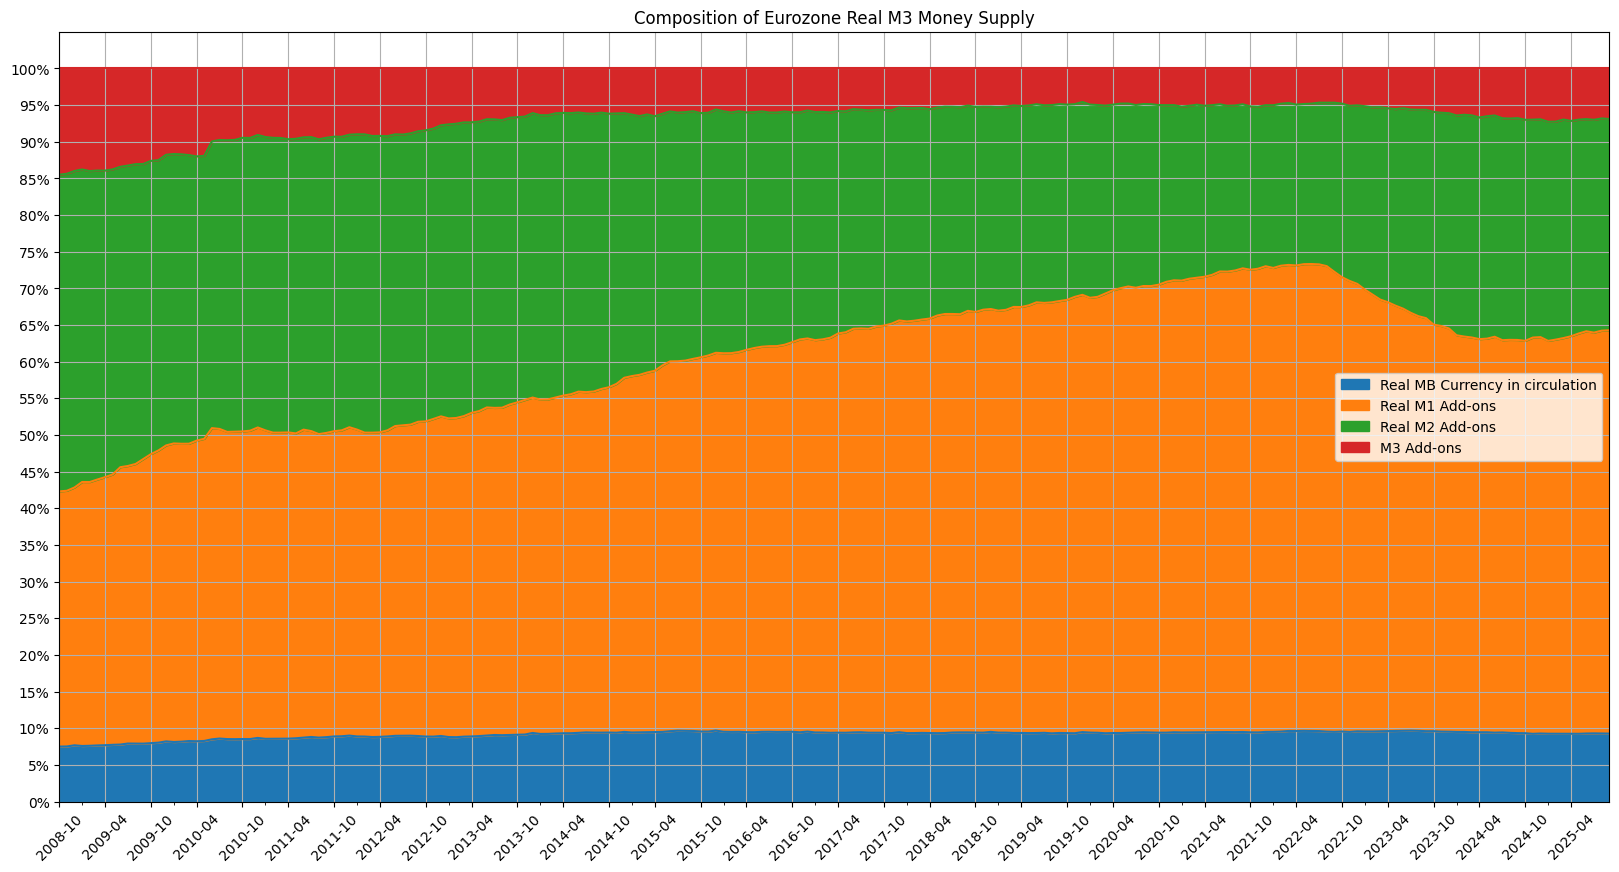

In [21]:
# Converting to percentages by dividing by total M3 Money Supply.
# Dividing by the total M3 Money Supply
m3real_df_pct = m3real_df.iloc[:,1:].divide(m3real_df.iloc[:,0], axis=0)
m3real_df_pct *= 100

ax = m3real_df_pct.plot.area(figsize=(20,10), grid=True, title=REALM3_COMPOSITION_TITLE,
                             xticks=m3real_df_pct.index[::6], xlabel='', rot=45, yticks=np.arange(0, 101, 5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m3real_df_pct.index[::6])))

## Visualizing Annual Percentage Changes in the Main Components of Eurozone's M3 Money Supply

In [22]:
m3_df_speed = (m3_df - m3_df.shift(1)).dropna()

In [23]:
# Converting to annual percentage changes (changes from the corresponding month a year ago)
m3_annual_rate = m3_df.pct_change(12).dropna()

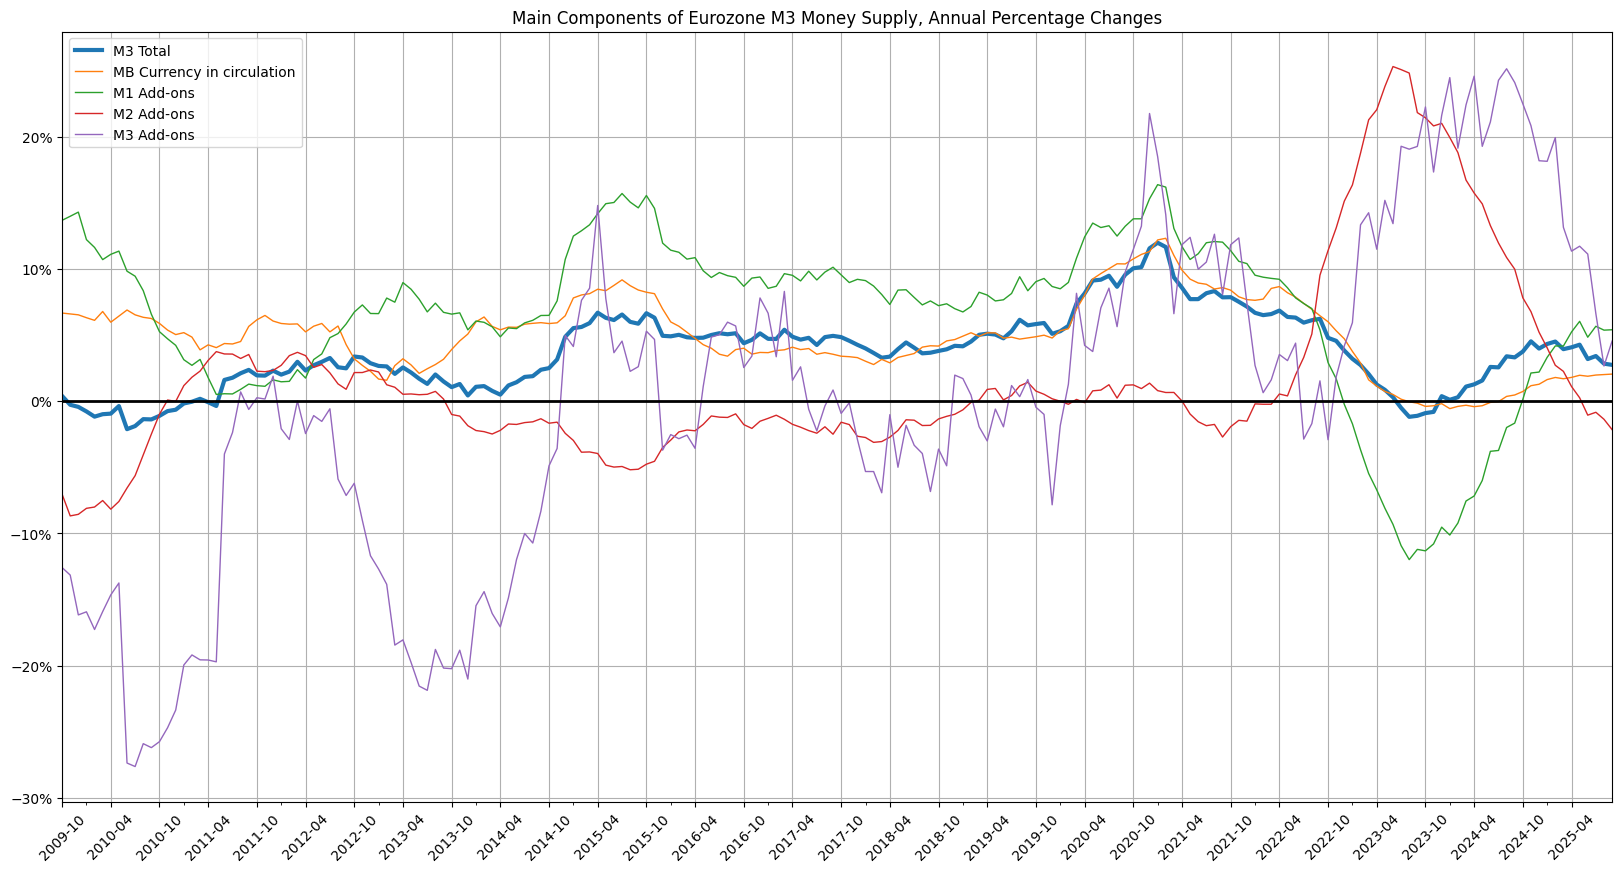

In [24]:
ax = m3_annual_rate.iloc[:,:1].plot(figsize=(20,10), grid=True, linewidth=3,
                                    title='Main Components of Eurozone M3 Money Supply, Annual Percentage Changes',
                                    xticks=m3_annual_rate.index[::6], xlabel='', rot=45)
m3_annual_rate.iloc[:,1:].plot(ax=ax, grid=True, xticks=m3_annual_rate.index[::6], xlabel='', rot=45, linewidth=1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=0, lw=2, c='k')
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m3_annual_rate.index[::6])))

In [25]:
pd.options.display.float_format = (lambda x: '{:.3%}'.format(x) if x < 100 else '{:,.0f}bn'.format(x))
m3_annual_rate.tail(12)

,M3 Total,MB Currency in circulation,M1 Add-ons,M2 Add-ons,M3 Add-ons
TIME_PERIOD,,,,,
2024-10-01,3.744%,0.724%,0.127%,7.806%,22.480%
2024-11-01,4.515%,1.161%,2.121%,6.765%,20.827%
2024-12-01,3.968%,1.272%,2.192%,5.203%,18.172%
2025-01-01,4.317%,1.624%,3.308%,4.023%,18.129%
2025-02-01,4.499%,1.784%,4.167%,2.705%,19.920%
2025-03-01,3.924%,1.687%,4.162%,2.246%,13.138%
2025-04-01,4.064%,1.789%,5.224%,1.100%,11.335%
2025-05-01,4.262%,1.950%,6.028%,0.249%,11.709%
2025-06-01,3.178%,1.877%,4.828%,-1.065%,11.114%


## Visualizing monthly and arbitrary term changes in the components of M3

In [26]:
M3_COMPONENTS_SPEED = 'Speed of changes in Eurozone M3 Money Supply in Billions of Euros per month'
M3_COMPONENTS_CHANGES = 'Changes in Components of Eurozone M3 Money Supply in Billions of Euros'
LEFT_Y_AXIS_LABEL = 'Billions of Euros'

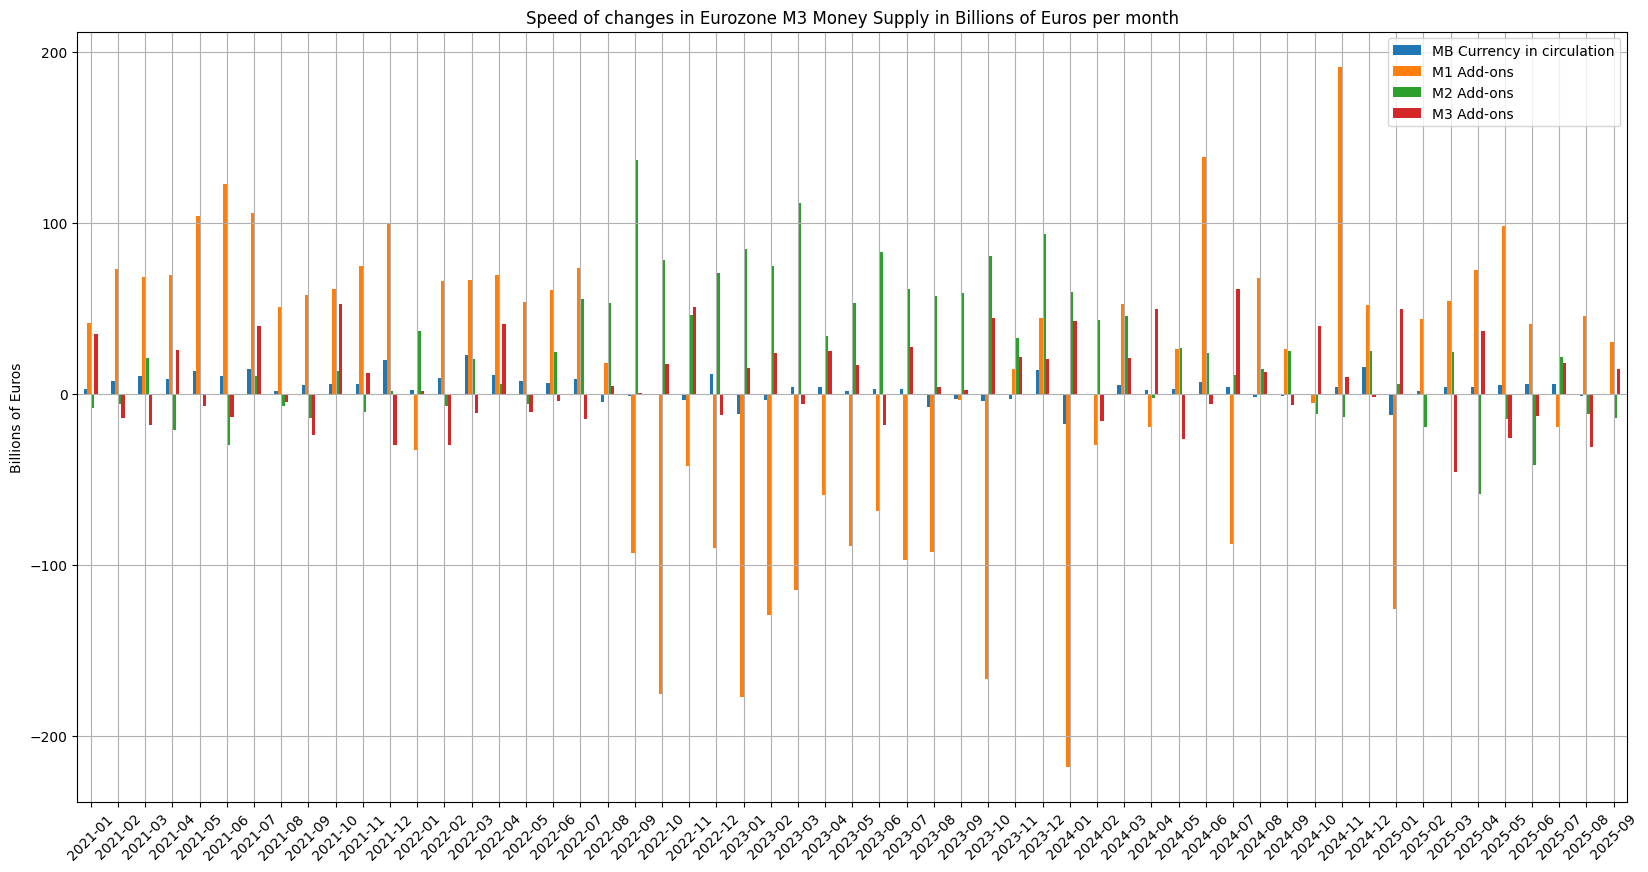

In [27]:
ax = m3_df_speed.loc['2021':, m3_df_speed.columns[1:]].plot.bar(figsize=(20,10), grid=True,
                            title=M3_COMPONENTS_SPEED, 
                            xlabel='', rot=45,
                            ylabel=LEFT_Y_AXIS_LABEL)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m3_df_speed.loc['2021':].index)))

In [28]:
# In months
periods = [12, 18]

In [29]:
# If you want to include currency in circulation, use iloc[-1, 1:] in the expression below
m3_df_comp_changes = pd.DataFrame([(m3_df - m3_df.shift(period)).iloc[-1, 2:] for period in periods], 
                                  index=['Over past {:d} month'.format(period) for period in periods])

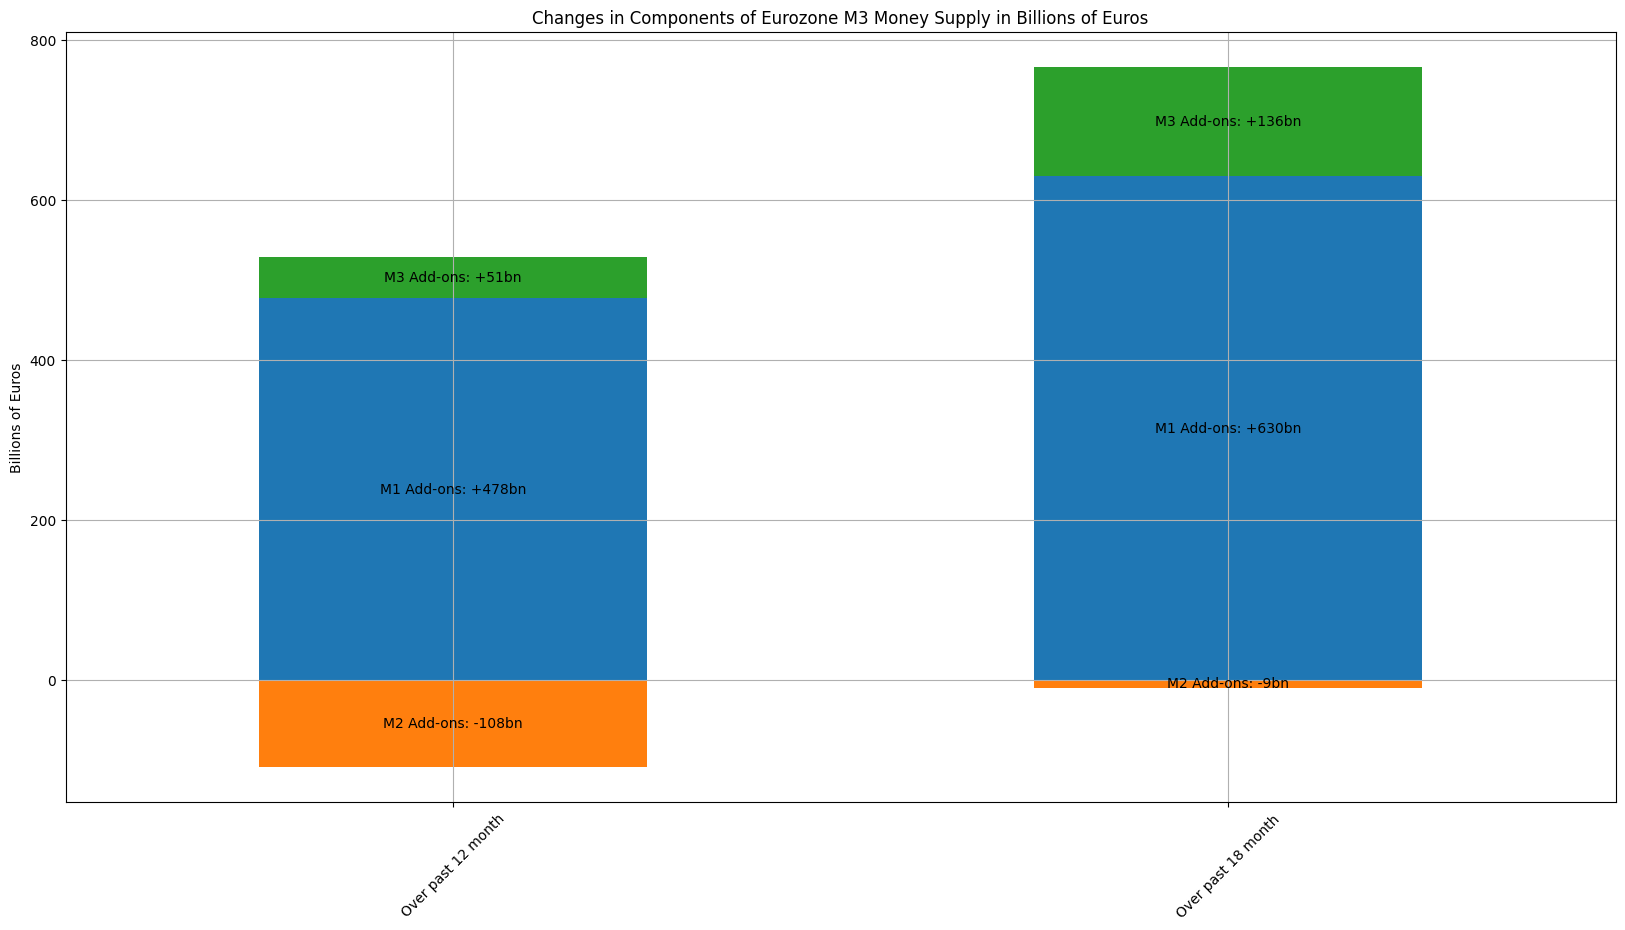

In [30]:
ax = m3_df_comp_changes.plot.bar(figsize=(20,10), grid=True, title=M3_COMPONENTS_CHANGES,
                                 stacked=True, rot=45, ylabel=LEFT_Y_AXIS_LABEL)
ax.get_legend().remove()
for c in ax.containers:
    ax.bar_label(c, fmt=c.get_label() + ': {:+.0f}bn', label_type='center')

Money supply changes in the past 3 months and in 3 months earlier

In [31]:
# In months
period = 3
offsets = [2*period, period]

In [32]:
# If you want to include currency in circulation, use iloc[-1, 1:] in the expression below
m3_df_comp_changes = pd.DataFrame([(m3_df.shift(offset-period) - m3_df.shift(offset)).iloc[-1, 2:] for offset in offsets], 
                                  index=['Over past {:d} to {:d} month'.format(offset, offset-period) for offset in offsets])

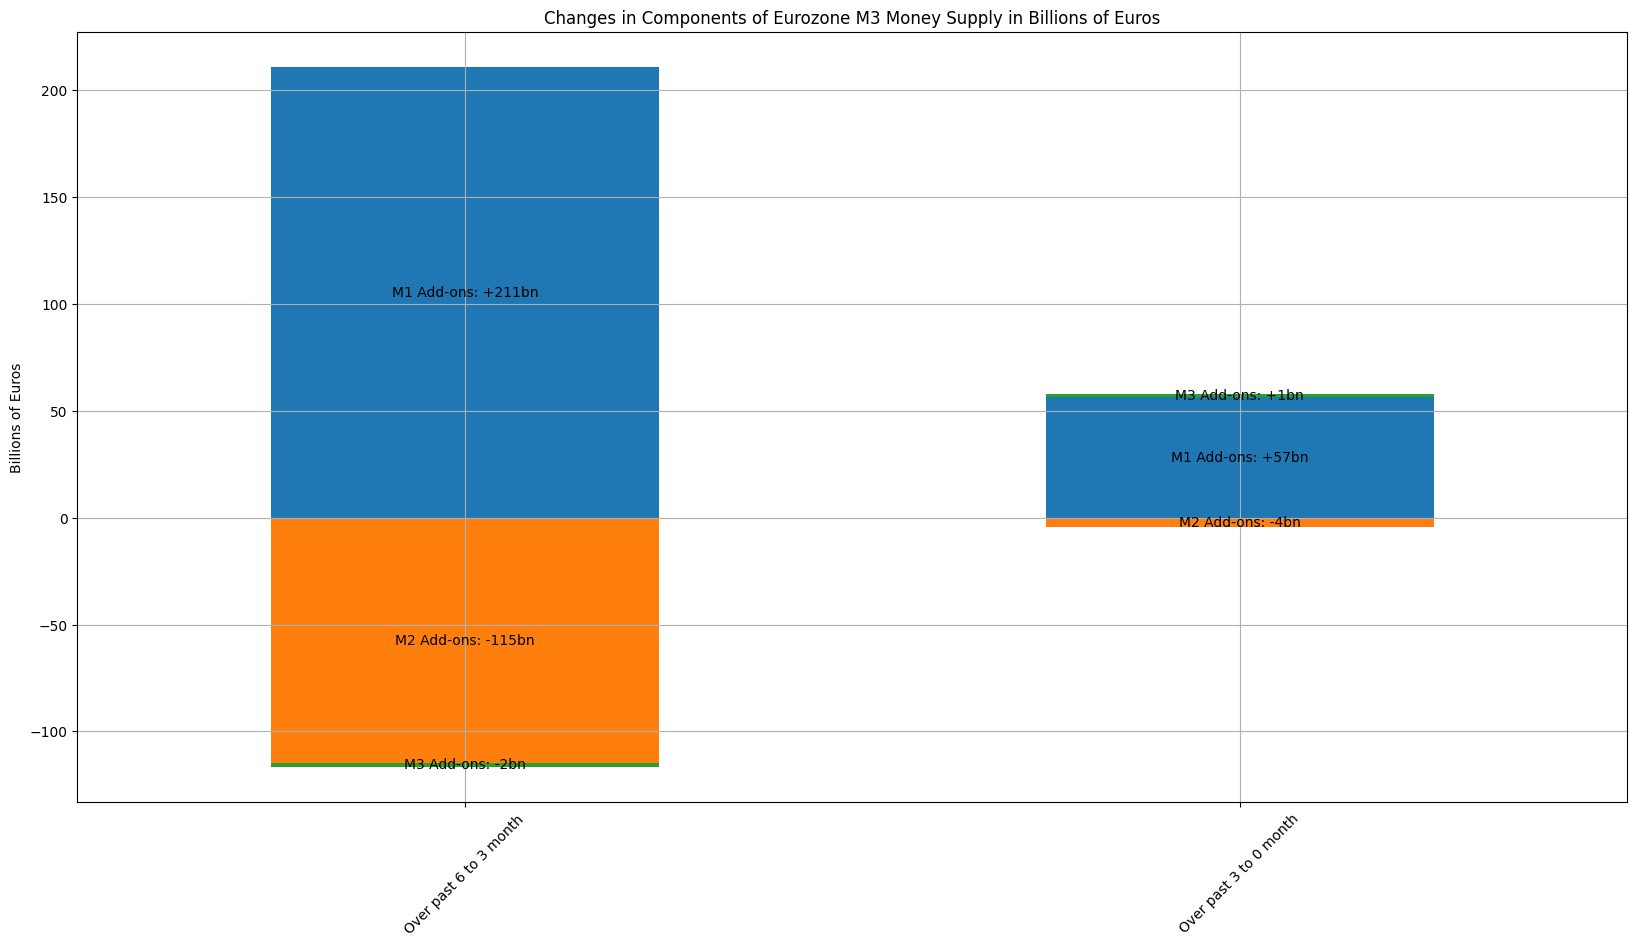

In [33]:
ax = m3_df_comp_changes.plot.bar(figsize=(20,10), grid=True, title=M3_COMPONENTS_CHANGES,
                                 stacked=True, rot=45, ylabel=LEFT_Y_AXIS_LABEL)
ax.get_legend().remove()
for c in ax.containers:
    ax.bar_label(c, fmt=c.get_label() + ': {:+.0f}bn', label_type='center')

In [34]:
m3real_annual_rate = m3real_df.pct_change(12).dropna()

In [35]:
m3real_annual_rate

,Real M3 Total,Real MB Currency in circulation,Real M1 Add-ons,Real M2 Add-ons,M3 Add-ons
TIME_PERIOD,,,,,
2009-10-01,0.515%,6.795%,13.816%,-6.925%,-12.478%
2009-11-01,-0.759%,6.076%,13.427%,-9.121%,-13.574%
2009-12-01,-1.357%,5.540%,13.234%,-9.408%,-16.942%
2010-01-01,-1.717%,5.304%,11.153%,-8.975%,-16.726%
2010-02-01,-2.007%,5.214%,10.680%,-8.785%,-17.967%
...,...,...,...,...,...
2025-05-01,2.325%,0.057%,4.059%,-1.613%,9.634%
2025-06-01,1.164%,-0.111%,2.782%,-2.996%,8.946%
2025-07-01,1.338%,-0.071%,3.544%,-2.830%,4.476%


In [36]:
m3_df_comp_changes.sum(axis=1)

Over past 6 to 3 month   9438.773%
Over past 3 to 0 month   5349.954%
dtype: float64

In [37]:
pd.options.display.float_format = '{:,.0f}bn'.format
m3_df_comp_changes

,M1 Add-ons,M2 Add-ons,M3 Add-ons
Over past 6 to 3 month,211bn,-115bn,-2bn
Over past 3 to 0 month,57bn,-4bn,1bn


## Analysis of the Reserve Balances component of Monetary Base
Monetary base is money that the central bank (the ECB in the case of the Euro Area) produces. It consists of:

* **Currency in circulation** &mdash; euro banknotes and coins in circulation domestically and abroad, which is a component of M1/M2/M3 broad money supply that I looked at earlier in this notebook; and
* **Reserve balances** &mdash; electronic central bank money that banks and other credit institutions hold in a reserve account directly at the ECB or national central banks of Eurozone countries.

[The ECB](https://data.ecb.europa.eu) devides reserve balances into:
*  **The current accounts of credit institutions at the Eurosystem**. These accounts cover the minimum reserves that banks are required to hold (currently set at 1% of customers' deposits)<sup>[1]</sup>, as well as any additional balances used for operational purposes. As of 20<sup>th</sup> September 2023, balances on these accounts are not rewarded with the deposit facility rate. The ECB provides this dataset to retrieve them: `ILM.M.U2.C.L020100.U2.EUR` &mdash; Millions of Euros (monthly frequency).
*  **The deposit facility balances of credit institutions**. It represents the amount of money that credit institutions have placed in the ECB’s deposit facility, typically as excess reserves beyond their required minimum. These balances are subject to the ECB's overnight deposit facility rate. The ECB provids this dataset to retrieve them: `ILM.M.U2.C.L020200.U2.EUR` &mdash; Millions of Euros (monthly frequency).

And this series from the [Eurostat](https://ec.europa.eu/eurostat/web/main/data/database):
* `namq_10_gdp` &mdash; Gross Domestic Product for the Eurozone, current prices, millions of Euros (quarterly frequency, from 1996). I need this series in order to calculate _the reserves to GDP ratio_.

Even though reserve balances are not available to private individuals and companies and are thus not part of money supply, they still play an indirect role in it by 1) limiting bank credit and M1 (see the footnone below) and 2) in certain additional cases because banks and other FIs are able to convert them into M1, e.g.:
* If a bank uses its reserves to buy assets, such as government bonds, from a non-bank entity (e.g., a pension fund or individual), the transaction increases M1.
* If a bank uses reserves to withdraw physical currency from the ECB and distributes it (e.g., via ATMs), this shifts reserves into currency in circulation, which is part of M1.
* Another way a bank might use reserves to affect M1 is by distributing its own funds, such as paying dividends to shareholders.

[1] In contrast to the Federal reserve in the US, the ECB still uses the _fractional reserve banking_ requirement, which stipulats that commercial banks needed to reserve a certain percentage of customer deposits as reserve at the central bank. The reserve requirement applied only to transactional deposits and used to be 2% before January 18<sup>th</sup> 2012 and 1% since then. Its purpose is to limit M1 money supply from commercial banks. To see how it works is easy with an example. I will stick with a 1% reserve requirement for the purposes of illustrating the point. A `€100` deposit leads to a maximum `€99` of lending (given that 1% of `€100` must be reserved at a central bank account), which leads to a further `€99 - €0.99 = €98.01` of deposits in the banking system, which leads to a maximum of further `€97.02` of lending, etc. As this process continues, the total money supply (M1) that's created is 99 + 98.01 + 97.02 + ... = `€10000`. If a resere requirement were 20%, a `€100` deposit would lead to maxumum of `€400` lending in the banking system.

In [38]:
data_msg = ecb.data('ILM', key='M.U2.C..U2.EUR', params={'startPeriod': report_start, 
                                                         'endPeriod': report_end})

In [39]:
rb_df = sdmx.to_pandas(data_msg.data[0])
rb_df = rb_df.loc['M', 'U2', 'C', :, 'U2', 'EUR'].unstack(-2).loc[:, ['L020100', 'L020200']]
rb_df = rb_df.set_axis(pd.DatetimeIndex(rb_df.index))
rb_df = rb_df.resample('MS').asfreq().ffill()
rb_df.columns.names = [None]

In [40]:
rb_df.L020100 += rb_df.L020200
rb_df = rb_df.iloc[:,:1]

In [41]:
# Get not seasonally adjusted nominal annual GDP of the Euro area
gdp = eurostat.get_data_df('namq_10_gdp', filter_pars={
    'startPeriod': (report_start - pd.DateOffset(months=9)).date(),
    'unit': 'CP_MEUR', 's_adj': 'NSA', 'na_item': 'B1GQ', 'geo': 'EA'}).iloc[:, 4:]
gdp = gdp.set_index(gdp.columns[0]).T
gdp = gdp.set_axis(pd.DatetimeIndex(gdp.index, 'QS'))
gdp = gdp.rolling(4).sum().dropna()

# Upsampling to monthly frequencies to match the frequency of S&P 500 metrics
gdp = gdp.EA.resample('MS').ffill()

In [42]:
rb_df['MB Reserves to GDP'] = rb_df.L020100 / gdp
rb_df.rename(columns={'L020100': 'MB Reserve Balances'}, inplace=True)
rb_df = rb_df.ffill()

In [43]:
pd.options.display.float_format = (lambda x: '{:.3%}'.format(x) if x < 100 else '€{:,.0f}mn'.format(x))
rb_df

,MB Reserve Balances,MB Reserves to GDP
TIME_PERIOD,,
2008-10-01,"€236,691mn",2.483%
2008-11-01,"€432,272mn",4.535%
2008-12-01,"€419,570mn",4.401%
2009-01-01,"€459,954mn",4.867%
2009-02-01,"€397,493mn",4.206%
...,...,...
2025-05-01,"€2,978,528mn",19.203%
2025-06-01,"€2,912,744mn",19.203%
2025-07-01,"€2,842,641mn",19.203%


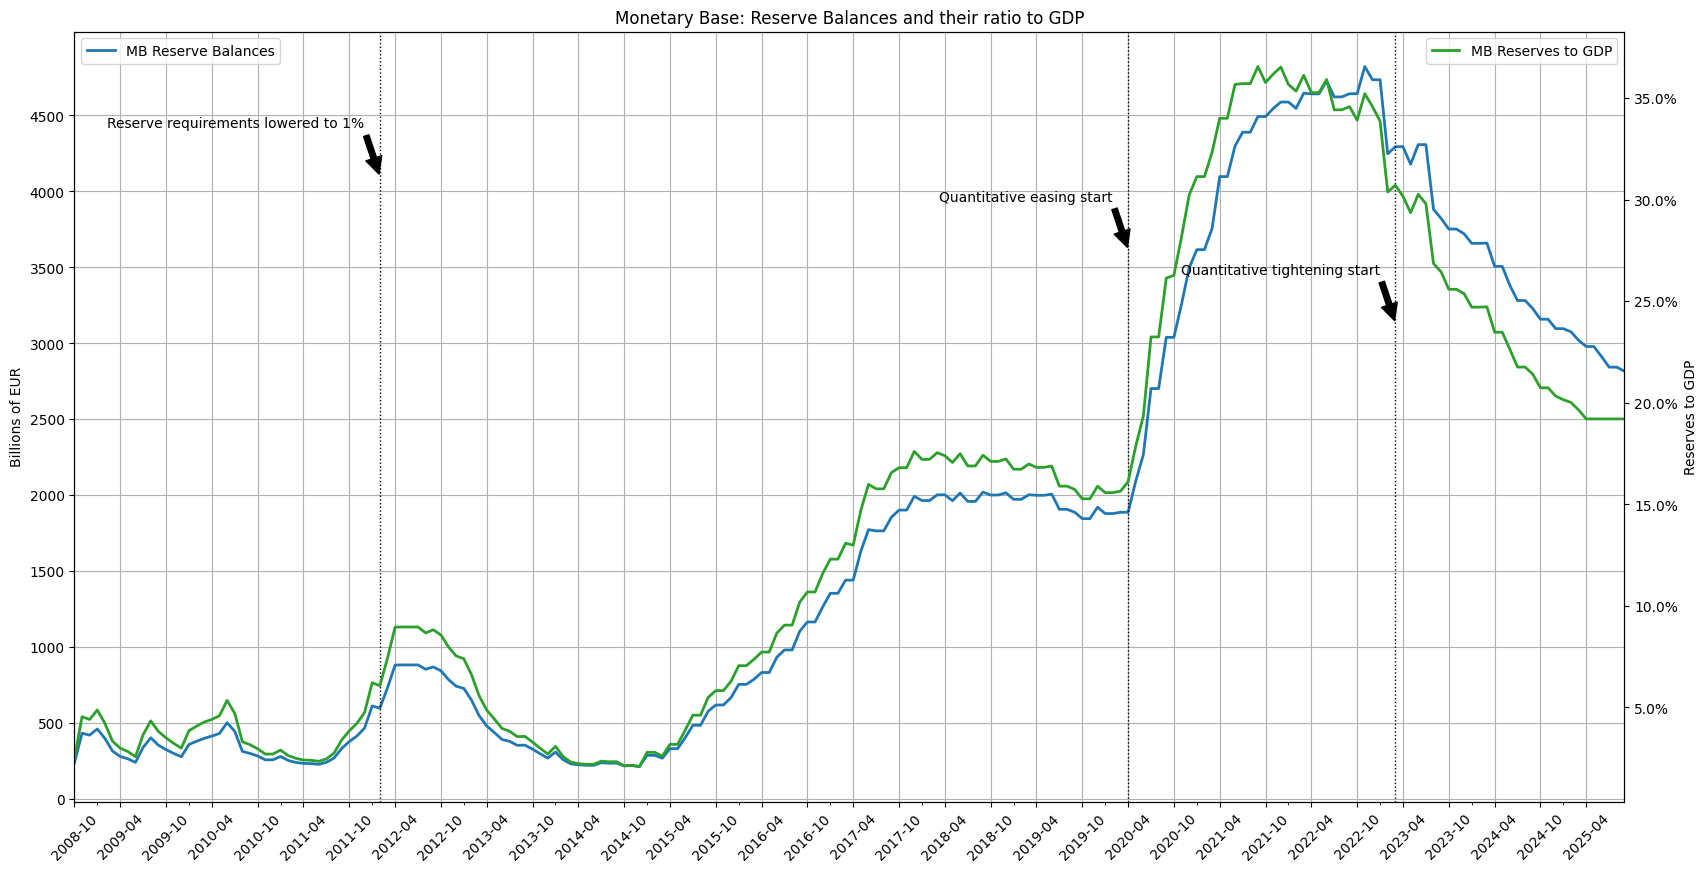

In [44]:
LEFT_Y_AXIS_LABEL = 'Billions of EUR'
RIGHT_Y_AXIS_LABEL = 'Reserves to GDP'
RESERVE_REQ_LOWERING_DATE = '2012-02-01'
QE_DATE = '2020-04-01'
QT_DATE = '2023-03-01'
y_max = rb_df.iloc[:,0].max()
y_step = rb_df.iloc[:,0].max() / 15

ax = rb_df.iloc[:,:1].plot(figsize=(20,10), grid=True,
                           title='Monetary Base: Reserve Balances and their ratio to GDP', ylabel=LEFT_Y_AXIS_LABEL,
                           xticks=rb_df.index[::6], xlabel='', rot=45, linewidth=2,
                           yticks=np.arange(0, y_max + 1, 500000))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1000:.0f}'))
ax.axvline(rb_df.index[rb_df.index.get_loc(RESERVE_REQ_LOWERING_DATE)], color='k',
           linestyle=':', linewidth=1)
ax.axvline(rb_df.index[rb_df.index.get_loc(QE_DATE)], color='k',
           linestyle=':', linewidth=1)
ax.axvline(rb_df.index[rb_df.index.get_loc(QT_DATE)], color='k',
           linestyle=':', linewidth=1)
x1 = rb_df.index[rb_df.index.get_loc(RESERVE_REQ_LOWERING_DATE)]
y1 = y_max * .85
x2 = rb_df.index[rb_df.index.get_loc(RESERVE_REQ_LOWERING_DATE) - 2]
y2 = y1 + y_step
ax.annotate('Reserve requirements lowered to 1%',
            xy=(x1, y1), xytext=(x2, y2), horizontalalignment='right',
            arrowprops=dict(facecolor='black', shrink=0.05))

x1_ = rb_df.index[rb_df.index.get_loc(QE_DATE)]
y1_ = y_max * .75
x2_ = rb_df.index[rb_df.index.get_loc(QE_DATE) - 2]
y2_ = y1_ + y_step
ax.annotate('Quantitative easing start',
            xy=(x1_, y1_), xytext=(x2_, y2_), horizontalalignment='right',
            arrowprops=dict(facecolor='black', shrink=0.05))

x1__ = rb_df.index[rb_df.index.get_loc(QT_DATE)]
y1__ = y_max * .65
x2__ = rb_df.index[rb_df.index.get_loc(QT_DATE) - 2]
y2__ = y1__ + y_step
ax.annotate('Quantitative tightening start',
            xy=(x1__, y1__), xytext=(x2__, y2__), horizontalalignment='right',
            arrowprops=dict(facecolor='black', shrink=0.05))

_ = ax.legend(loc='upper left')
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2 = rb_df.iloc[:,1].plot(ax=ax2, linewidth=2, linestyle='-', ylabel=RIGHT_Y_AXIS_LABEL,
     xticks=rb_df.index[::6], color=['#2ca02c','#d62728'])
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2.set_xticklabels(list(map('{:%Y-%m}'.format, rb_df.index[::6])))
_ = ax2.legend(loc='upper right')